<a href="https://colab.research.google.com/github/NagaKartheekReddy/DPhi_Datathon_Challenges/blob/main/ImageClassification_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statemet :**
Artificial intelligence (AI) is 
predicted to have profound effects on the future of video
capsule endoscopy (VCE) technology.The potential lies in improving anomaly detection while reducing manual labour. However, medical data is often sparse and unavailable to the research community, and qualified medical personnel rarely have time for the tedious labelling work.

In [18]:
# Download the dataset from google drive
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1yDcNMTI-8Zq2Mvs8qe7pLNpPx4BW5Yta',
dest_path='My Drive/Colab Notebooks/dpi/The Kvasir-Capsule.zip',
unzip=True)

In [2]:
# Data analysis and manipultion tool
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import tensorflow as tf

In [3]:
labels = pd.read_csv("My Drive/Colab Notebooks/dpi/The Kvasir-Capsule/Training_set.csv") # loading the labels
labels.head()

,filename,label
0,Image_1.jpg,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa
2,Image_3.jpg,Foreign body
3,Image_4.jpg,Normal clean mucosa
4,Image_5.jpg,Normal clean mucosa


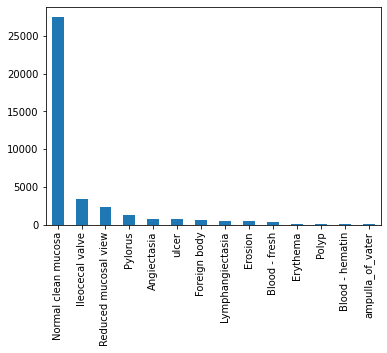

In [4]:
# distribution of labels plot
labels['label'].value_counts().plot.bar()

In [5]:
file_paths = ['My Drive/Colab Notebooks/dpi/The Kvasir-Capsule/train/' + fname for fname in labels['filename']]
labels['filepaths'] = file_paths
labels.head()

,filename,label,filepaths
0,Image_1.jpg,Normal clean mucosa,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
1,Image_2.jpg,Normal clean mucosa,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
2,Image_3.jpg,Foreign body,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
3,Image_4.jpg,Normal clean mucosa,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
4,Image_5.jpg,Normal clean mucosa,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...


In [6]:
# encode the categorical labels into numerical
le = LabelEncoder()
labels['label']= le.fit_transform(labels.label.values)
labels.head()

,filename,label,filepaths
0,Image_1.jpg,8,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
1,Image_2.jpg,8,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
2,Image_3.jpg,5,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
3,Image_4.jpg,8,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...
4,Image_5.jpg,8,My Drive/Colab Notebooks/dpi/The Kvasir-Capsul...


In [7]:
# train and test data spilt step
x_train, x_test = train_test_split(labels, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(30232, 3) (7558, 3)


In [8]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [9]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=x_train,
directory=None,
x_col="filepaths",
y_col="label",
batch_size=64,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 30232 validated image filenames.


In [10]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe(
dataframe= x_test,
x_col= "filepaths",
y_col= "label",
batch_size= 64,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7558 validated image filenames.


In [11]:
# Build CNN model using convolution layers of pertrained state of art Xception model
xception = Xception(include_top=False, weights="imagenet",input_shape=(224, 224, 3))
x= xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

output_layer = Dense(14, activation='softmax')(x)

xception_model = Model(inputs=xception.input,outputs=output_layer)

83689472/83683744 [==============================] - 1s 0us/step


In [12]:
optim = tf.keras.optimizers.Adam(lr=0.00001,decay=0.0001)
xception_model.compile(optimizer = optim,
    metrics=["acc"],
    loss= tf.keras.losses.sparse_categorical_crossentropy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
import os
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [14]:
my_callbacks = [
ModelCheckpoint(checkpoint_path, monitor = 'val_acc',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [15]:
# Add class weigths for each label to tackle class imbalance problem
class_weights = class_weight.compute_class_weight('balanced',
classes= np.unique(x_train.label.values),
y= x_train.label.values)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 3.976848197842673,
 1: 7.15042573320719,
 2: 239.93650793650792,
 3: 6.624014022787029,
 4: 21.594285714285714,
 5: 4.398021530404423,
 6: 0.806057697435077,
 7: 5.466907775768536,
 8: 0.09816030598793452,
 9: 71.98095238095237,
 10: 2.230814639905549,
 11: 1.1819532410665416,
 12: 359.9047619047619,
 13: 3.876891510643755}

In [16]:
# train the model
xception_model.fit(
train_generator,
epochs=100,
validation_data=valid_generator,
callbacks=my_callbacks,
class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
473/473 [==============================] - 736s 1s/step - loss: 1.9245 - acc: 0.1198 - val_loss: 2.5926 - val_acc: 0.1609

Epoch 00001: val_acc improved from -inf to 0.16089, saving model to xception_best.ckpt
Epoch 2/100
473/473 [==============================] - 687s 1s/step - loss: 1.1871 - acc: 0.1958 - val_loss: 2.4212 - val_acc: 0.2110

Epoch 00002: val_acc improved from 0.16089 to 0.21103, saving model to xception_best.ckpt
Epoch 3/100
473/473 [==============================] - 687s 1s/step - loss: 0.8362 - acc: 0.2683 - val_loss: 2.2253 - val_acc: 0.2843

Epoch 00003: val_acc improved from 0.21103 to 0.28433, saving model to xception_best.ckpt
Epoch 4/100
473/473 [==============================] - 689s 1s/step - loss: 0.6570 - acc: 0.3349 - val_loss: 2.1417 - val_acc: 0.2916

Epoch 00004: val_acc improved from 0.28433 to 0.29161, 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f54b6b81830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 20/100
 33/473 [=>............................] - ETA: 9:45 - loss: 0.1726 - acc: 0.9683

KeyboardInterrupt: ignored

In [19]:
# read the csv file
test_data = pd.read_csv("My Drive/Colab Notebooks/dpi/The Kvasir-Capsule/Testing_set.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test_data,
directory= "My Drive/Colab Notebooks/dpi/The Kvasir-Capsule/test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 9448 validated image filenames.


In [20]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
pred

9448/9448 [==============================] - 121s 13ms/step


array([[4.6485841e-02, 2.9319294e-02, 8.0596238e-02, ..., 5.8694426e-02,
        3.9475121e-02, 7.0216484e-02],
       [5.9101842e-02, 3.3501778e-02, 8.5747659e-02, ..., 6.4154655e-02,
        4.0755652e-02, 7.2688013e-02],
       [6.9035329e-02, 4.2409997e-02, 6.5917149e-02, ..., 1.1944566e-01,
        2.8279601e-02, 6.5271780e-02],
       ...,
       [9.8706937e-01, 2.2764891e-04, 6.4472505e-04, ..., 1.8310764e-04,
        1.5105809e-04, 3.1875246e-05],
       [5.0684646e-02, 8.1876060e-03, 2.6406398e-02, ..., 7.3810411e-03,
        1.2392551e-02, 1.0803576e-02],
       [2.4208356e-02, 4.0920572e-03, 2.2245329e-03, ..., 6.0997414e-03,
        4.1460510e-02, 6.8780771e-03]], dtype=float32)

In [21]:
df_submit = pd.DataFrame({'filename': test_data['filename'],"label":np.argmax(pred, axis= 1)})
df_submit

,filename,label
0,Image_1.jpg,8
1,Image_2.jpg,8
2,Image_3.jpg,5
3,Image_4.jpg,6
4,Image_5.jpg,8
...,...,...
9443,Image_9444.jpg,10
9444,Image_9445.jpg,8
9445,Image_9446.jpg,0
9446,Image_9447.jpg,6


In [22]:
df_submit['label']= le.inverse_transform(df_submit.label.values)
df_submit

,filename,label
0,Image_1.jpg,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa
2,Image_3.jpg,Foreign body
3,Image_4.jpg,Ileocecal valve
4,Image_5.jpg,Normal clean mucosa
...,...,...
9443,Image_9444.jpg,Pylorus
9444,Image_9445.jpg,Normal clean mucosa
9445,Image_9446.jpg,Angiectasia
9446,Image_9447.jpg,Ileocecal valve


In [23]:
df_submit.to_csv("submission.csv", index = False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Accuracy acheived on submission data is 95.96**. [leaderboard link](https://dphi.tech/challenges/data-sprint-38-the-kvasir-capsule-dataset/129/leaderboard/practice/)